In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%aimport utils

In [3]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from utils import load_embeddings_and_ids, concatenate_featmats, plot_images

### Loading Features

In [4]:
resnet50 = load_embeddings_and_ids('/mnt/workspace/Ugallery/ResNet50/', 'flatten_1.npy', 'ids')

In [5]:
# alexnet = load_embeddings_and_ids('/mnt/workspace/Ugallery/AlexNet/', 'fc7.npy', 'ids.npy')

In [6]:
# inceptionv3 = load_embeddings_and_ids('/mnt/workspace/Ugallery/InceptionV3/', 'avg_pool.npy', 'ids')

In [7]:
# vgg19 = load_embeddings_and_ids('/mnt/workspace/Ugallery/VGG19/', 'fc2.npy', 'ids')

In [8]:
# incepresv2 = load_embeddings_and_ids('/mnt/workspace/Ugallery/InceptionResnetV2/', 'avg_pool.npy', 'ids')

In [5]:
embedding_list = [
    resnet50,
#     alexnet,
#     inceptionv3,
#     vgg19,
#     incepresv2,
]

### Combining features and applying PCA

In [6]:
artwork_ids = set()
artwork_ids.update(resnet50['index2id'])
# artwork_ids.intersection_update(alexnet['index2id'])
# artwork_ids.intersection_update(inceptionv3['index2id'])
# artwork_ids.intersection_update(vgg19['index2id'])
# artwork_ids.intersection_update(incepresv2['index2id'])

In [7]:
len(artwork_ids)

13297

In [8]:
featmat_list = [tmp['featmat'] for tmp in embedding_list]
id2index_list = [tmp['id2index'] for tmp in embedding_list]
concat_featmat = concatenate_featmats(artwork_ids, featmat_list, id2index_list)

In [9]:
concat_featmat.shape

(13297, 2048)

In [10]:
std_scaler = StandardScaler()

In [11]:
concat_featmat_zscored = std_scaler.fit_transform(concat_featmat)

In [12]:
pca200_concat = PCA(n_components=200).fit_transform(concat_featmat_zscored)

In [13]:
pca200_concat.shape

(13297, 200)

In [14]:
from os import makedirs
# dirpath = '/mnt/workspace/Ugallery/PCA200(resnet50+alexnet+inceptionv3+vgg19+incepresv2)/'
dirpath = '/mnt/workspace/Ugallery/PCA200(resnet50)/'
makedirs(dirpath, exist_ok=True)
np.save(dirpath + 'embeddings.npy', pca200_concat)
np.save(dirpath + 'ids.npy', np.array(list(artwork_ids)))

### K-Means Clustering

In [17]:
best_score=None
best_clusterer=None

In [19]:
for _ in range(10):
    print(_,' ---------------------------------')
    clusterer = KMeans(n_clusters=100, max_iter=2000, n_init=8, n_jobs=8).fit(pca200_concat)
    cluster_labels = clusterer.predict(pca200_concat)
    silhouette_avg = silhouette_score(pca200_concat, cluster_labels)
    if best_score is None or best_score < silhouette_avg:
        best_score = silhouette_avg
        best_clusterer = clusterer
    print("Average silhouette_score is :", silhouette_avg)

0  ---------------------------------
Average silhouette_score is : 0.008850387854216808
1  ---------------------------------
Average silhouette_score is : 0.007543795032561275
2  ---------------------------------
Average silhouette_score is : 0.007542587160243628
3  ---------------------------------
Average silhouette_score is : 0.0011919550306787828
4  ---------------------------------
Average silhouette_score is : 0.002172478338129263
5  ---------------------------------
Average silhouette_score is : 0.006226040873320517
6  ---------------------------------
Average silhouette_score is : 0.005168892073255646
7  ---------------------------------
Average silhouette_score is : 0.007372273195680984
8  ---------------------------------
Average silhouette_score is : 0.0065168640937565536
9  ---------------------------------
Average silhouette_score is : 0.007606797488450961


In [20]:
index2id = list(artwork_ids)

In [21]:
best_cluster_labels = best_clusterer.predict(pca200_concat)

In [22]:
silhouette_score(pca200_concat, best_cluster_labels)

0.008850387854216808

In [23]:
artwork_id_2_cluster_id = { aid:int(cid) for aid,cid in zip(index2id, best_cluster_labels) }

In [24]:
import json
from os import makedirs
makedirs('/mnt/workspace/Ugallery/Clustering/', exist_ok=True)
# with open('/mnt/workspace/Ugallery/Clustering/artworkId2clusterId(resnet50+alexnet+inceptionv3+vgg19+incepresv2).json',
with open('/mnt/workspace/Ugallery/Clustering/artworkId2clusterId(resnet50).json',
          'w') as f:
    json.dump(artwork_id_2_cluster_id, f)

### Visualize Clusters

In [25]:
import random
import matplotlib.pyplot as plt

In [26]:
N_CLUSTERS = 100

In [27]:
image_cache = dict()

In [28]:
artwork_ids_by_cluster = {i:[] for i in range(N_CLUSTERS)}
for aid,cid in artwork_id_2_cluster_id.items():
    artwork_ids_by_cluster[cid].append(aid)
for i in range(N_CLUSTERS):
    assert len(artwork_ids_by_cluster[i]) > 0

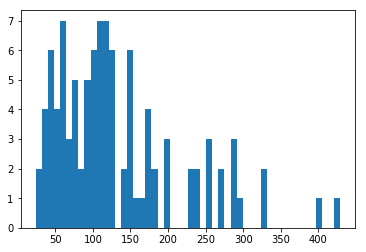

In [29]:
plt.hist([len(x) for x in artwork_ids_by_cluster.values()], bins=50)
plt.show()

In [30]:
def plot_image_sample(cluster_id=None, n_samples=20, n_clusters=100):
    if cluster_id is None:
        cluster_id = np.random.randint(n_clusters)
        
    ids = artwork_ids_by_cluster[cluster_id]
    if len(ids) > n_samples:
        sample_ids = random.sample(ids, n_samples)
    else:
        sample_ids = ids
    n = len(sample_ids)
    
    print('----- cluster_id = %d, size = %d ------' % (cluster_id, len(ids)))
        
    plot_images(plt, image_cache, sample_ids)

----- cluster_id = 76, size = 65 ------


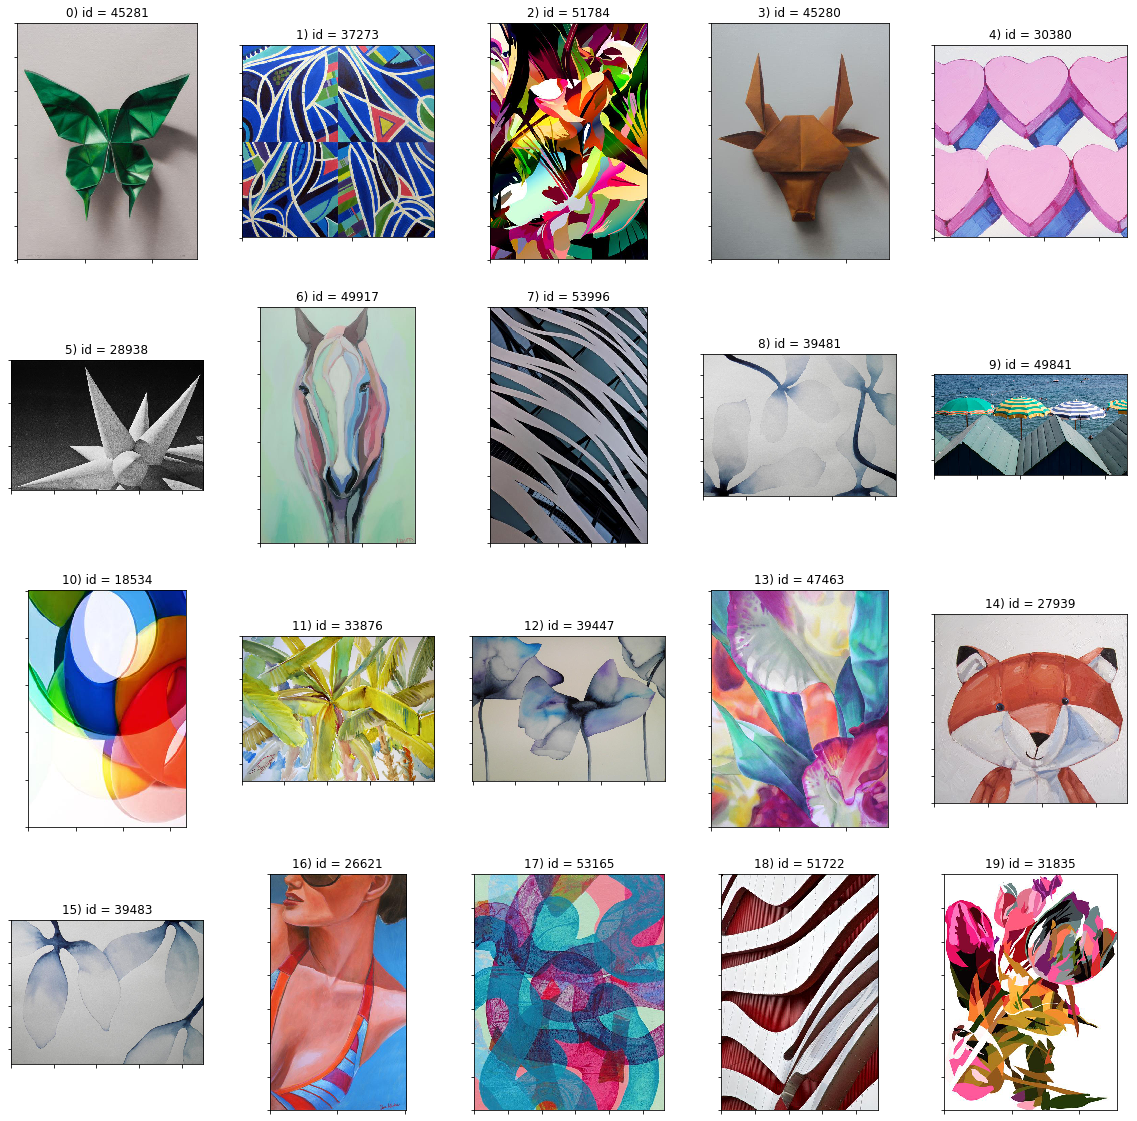

In [33]:
plot_image_sample(cluster_id=None, n_samples=20)